In [214]:
import pandas as pd
import numpy as np
import nltk
import requests
import string
import seaborn as sns
import matplotlib.pyplot as plt
import pymorphy2
import os
import gdown

from functools import partial
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from warnings import filterwarnings

In [2]:
filterwarnings('ignore')
sns.set_palette('viridis')
tqdm.pandas()
nltk.download('punkt')
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
ukrainian_stopwords = set(
    requests.request('get', 'https://raw.githubusercontent.com/skupriienko/Ukrainian-Stopwords/master/stopwords_ua.txt').content.decode('utf-8').splitlines()
)

In [215]:
# Download dataset
if not os.path.exists('./dataset.csv'):
    gdown.download(id='1h0rdgQHXcWB09OGh7P2gcwGZyqgrQOoH')

In [4]:
df = pd.read_csv('dataset.csv')

# How many messages are present per group

In [5]:
channels_count_df = (
    df.groupby(['label', 'sourced_lang','channel'])
    .agg({'text' :'count'})
    .rename(columns={
        'text':'messages_count'
    })
    .reset_index(level='channel')
    .groupby(['label', 'sourced_lang'])
    .agg({
        'channel': 'count',
        'messages_count': 'sum'
    })
    .rename(columns={
        'channel':'channels_count'
    })
)
temp_df = pd.concat([
    channels_count_df,
    pd.DataFrame([{
        'channels_count':0,
        'messages_count':0
    }], index=pd.MultiIndex.from_tuples([
        ('1', 'uk')
    ]))
]).rename(columns={
    'channels_count': 'Count of channels',
    'messages_count': 'Count of messages'
})
temp_df.index.names = ['Label', 'Sourced Lang']
display(temp_df)
# print(temp_df.to_latex())

Count of channels  Count of messages
Label Sourced Lang                                      
0     ru                            1               9507
      uk                            8             292875
1     ru                           36             553468
      uk                            0                  0

\begin{tabular}{llrr}
\toprule
  &    &  Count of channels &  Count of messages \\
Label & Sourced Lang &                    &                    \\
\midrule
0 & ru &                  1 &               9507 \\
  & uk &                  8 &             292875 \\
1 & ru &                 36 &             553468 \\
  & uk &                  0 &                  0 \\
\bottomrule
\end{tabular}



# How many messages do each channel has

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855850 entries, 0 to 855849
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   message_id    855850 non-null  int64 
 1   text          855850 non-null  object
 2   views         855850 non-null  int64 
 3   date          855850 non-null  object
 4   channel       855850 non-null  object
 5   label         855850 non-null  int64 
 6   sourced_lang  855850 non-null  object
dtypes: int64(3), object(4)
memory usage: 45.7+ MB


In [7]:
plt.rcParams['pgf.texsystem'] = 'xelatex'

In [ ]:
df['channel']

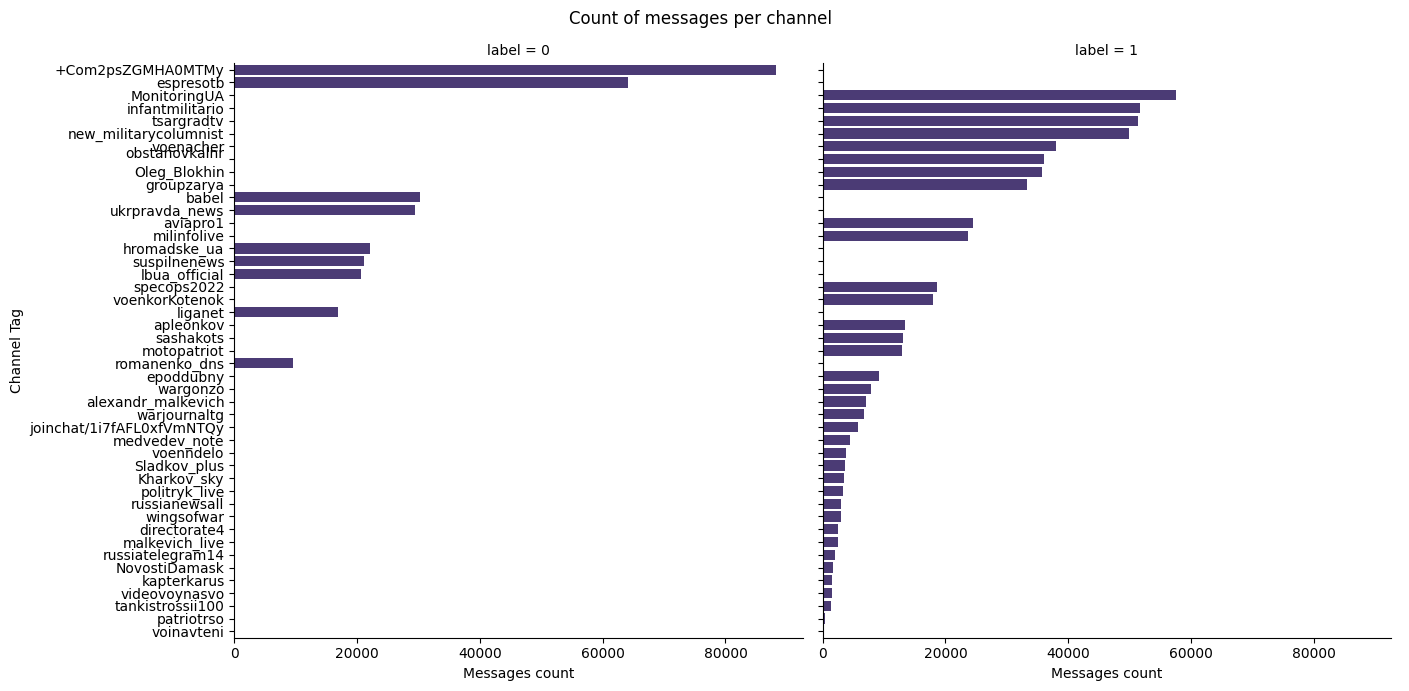

In [25]:
g = sns.catplot(data=df, 
            y='channel', 
            row='label', 
            kind='count',
            col='sourced_lang', 
            col_order=['ru', 'uk'],
            row_order=[0, 1],
            order=df['channel'].value_counts().index,
            height=7
           )

g.set_axis_labels('Messages count', 'Channel Tag')
g.fig.suptitle('Count of messages per channel')
plt.tight_layout()
# plt.savefig('count_of_messages_per_channel.pdf', bbox_inches='tight')

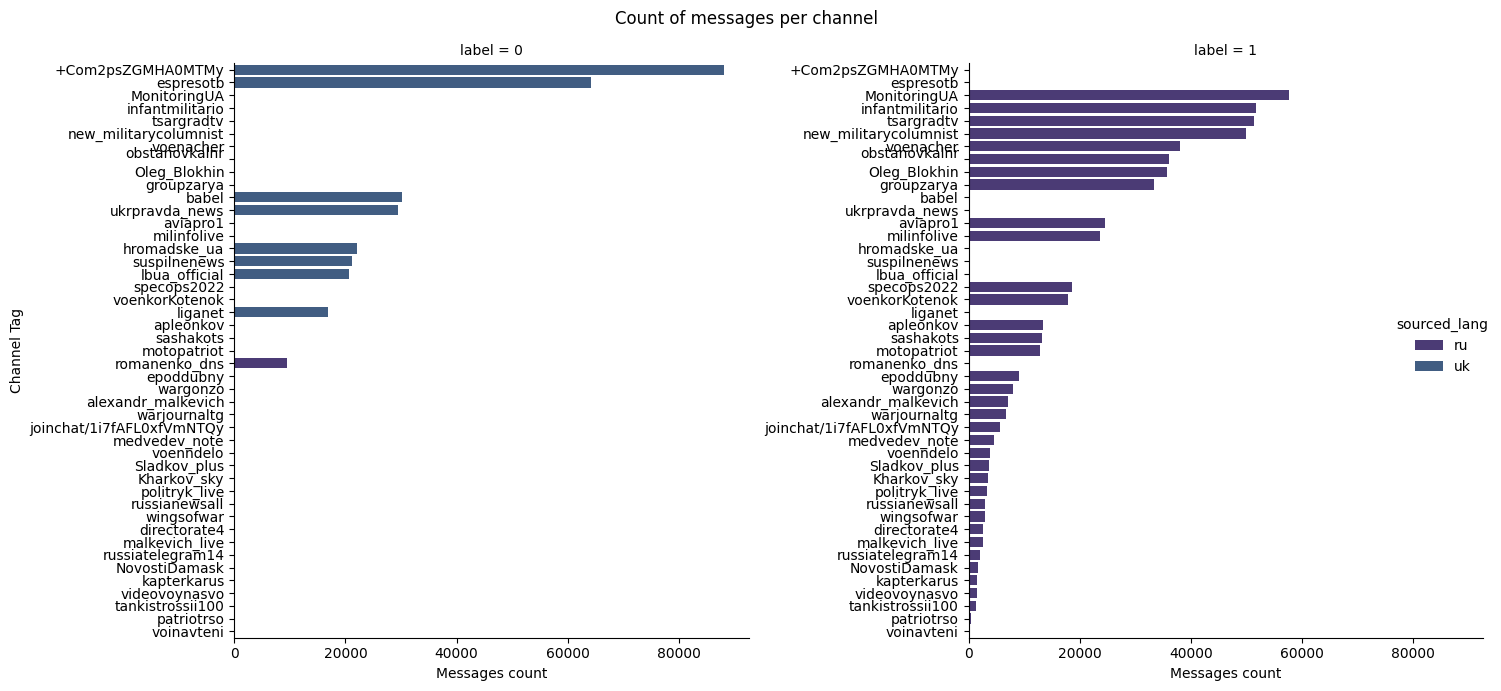

In [31]:
g = sns.catplot(data=df, 
            y='channel', 
            col='label', 
            kind='count',
            col_order=[0, 1],
            order=df['channel'].value_counts().index,
            height=7,
                sharey=False,
                hue='sourced_lang'
           )

g.set_axis_labels('Messages count', 'Channel Tag')
g.fig.suptitle('Count of messages per channel')
plt.tight_layout()
# plt.savefig('count_of_messages_per_channel.pdf', bbox_inches='tight')

# How many words do these messages contain

In [9]:
# For each category we will createa a dictionary
def word_length_in_df(df):
    
    messages_tokenized = df['text'].progress_apply(lambda x: nltk.word_tokenize(x)).tolist()
    messages_tokenized_flattened = set([j for i in messages_tokenized for j in i])
    vocab = set(messages_tokenized_flattened)
    words_length = [len(x) for x in vocab]
    return pd.Series(words_length, name='wordlen')

words_length = df.groupby(['label', 'sourced_lang']).apply(word_length_in_df)

100%|██████████| 553468/553468 [03:15<00:00, 2834.71it/s]


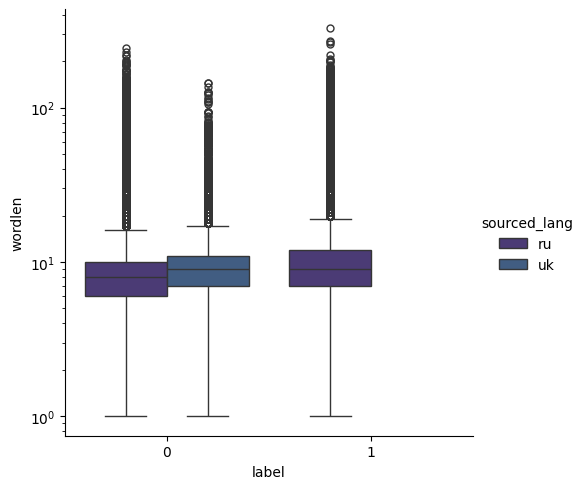

In [10]:
sns.catplot(
    data=words_length.reset_index(level=2, drop=True).reset_index(), 
    x='label', 
    y='wordlen',
    kind='box',
    hue='sourced_lang')
plt.yscale('log')

In [38]:
# For each category we will createa a dictionary
def message_len(df):
    return df.assign(
        message_len=df['text'].apply(len)
    )

message_lens = (
    df.groupby(['label', 'sourced_lang']).apply(message_len) 
)
message_lens

,message_id,text,views,date,channel,label,sourced_lang,message_len
0,39818,Ликвидированный российскими войсками 10 июня 2...,4357,2022-06-12 20:29:58+00:00,Oleg_Blokhin,1,ru,279
1,48968,США точно не поставят Киеву дальнобойное оружи...,1803,2023-05-10 08:55:43+00:00,MonitoringUA,1,ru,436
2,101269,⚠️ 💥 ЛЬВІВ — ВИБУХ.\n\nЧекаємо на офіційну ін...,16956,2023-07-05 23:34:27+00:00,+Com2psZGMHA0MTMy,0,uk,76
3,10693,Депутат Запорожского облсовета Евгений Балицки...,149223,2022-03-19 10:46:38+00:00,Oleg_Blokhin,1,ru,1006
4,19528,🇮🇱Рейд израильской армии в лагерь Дженин: шест...,10525,2023-03-07 18:38:05+00:00,aviapro1,1,ru,504
...,...,...,...,...,...,...,...,...
855845,9310,ОБЩАЛСЯ СЕГОДНЯ \nС ПЛЕННЫМ УКРАИНСКИМ ДЕСАНТН...,367149,2023-12-14 12:53:04+00:00,Sladkov_plus,1,ru,745
855846,29844,❗️Российские военные отбили у ВСУ несколько по...,16042,2023-07-02 07:23:38+00:00,aviapro1,1,ru,93
855847,99108,"❗️Украинский ТГ-канал ""Резидент"" со ссылкой на...",59621,2023-01-07 13:59:01+00:00,new_militarycolumnist,1,ru,290
855848,45762,"Минобороны РФ заявило, что страны, поддерживаю...",19360,2024-01-04 11:39:00+00:00,groupzarya,1,ru,470


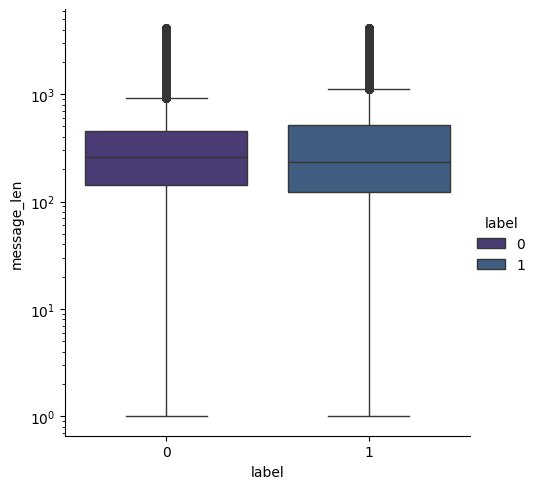

In [51]:
sns.catplot(
    data=message_lens, 
    x='label', 
    hue='label',
    y='message_len',
    kind='box',)

plt.yscale('log')

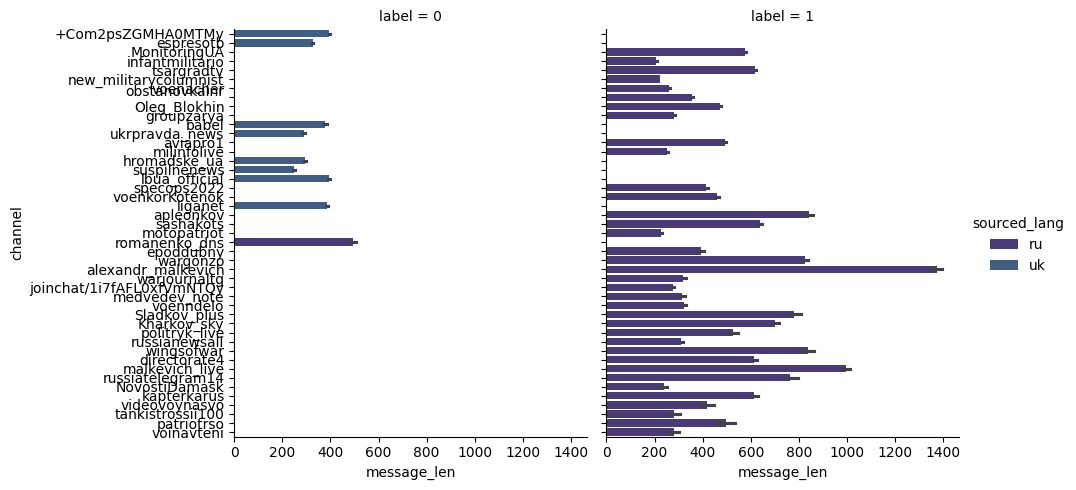

In [47]:
sns.catplot(
    data=message_lens, 
    y='channel',
    x='message_len',
    kind='bar',
col='label', hue='sourced_lang', order=df['channel'].value_counts().index)

# plt.xscale('log')
# plt.savefig('average_message_len_per_channel.pdf')

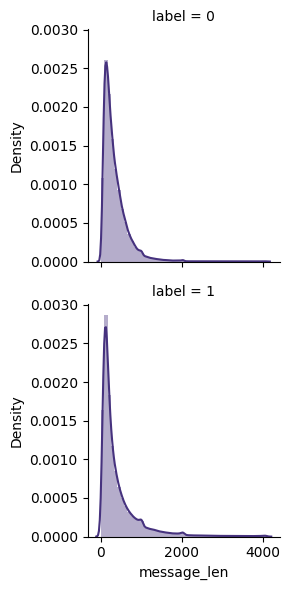

In [13]:
g = sns.FacetGrid(data=message_lens, row='label')
g.map(sns.distplot, 'message_len')


In [14]:
# Sence length in words
def sentence_length(df):
    messages_tokenized = df['text'].progress_apply(lambda x: nltk.sent_tokenize(x)).tolist()
    sentences = [j for i in messages_tokenized for j in i]
    words_per_sentence = [len(nltk.word_tokenize(s)) for s in sentences]
    chars_per_sentence = [len(s) for s in sentences]
    return pd.DataFrame({
        'words_per_sentence': words_per_sentence,
        'chars_per_sentence': chars_per_sentence
    })

sentence_len = (
    df.groupby(['label', 'sourced_lang']).apply(sentence_length)
    .reset_index(level=2, drop=True)).reset_index()

100%|██████████| 553468/553468 [00:40<00:00, 13779.34it/s]


In [15]:
sentence_len['words_per_sentence'] = np

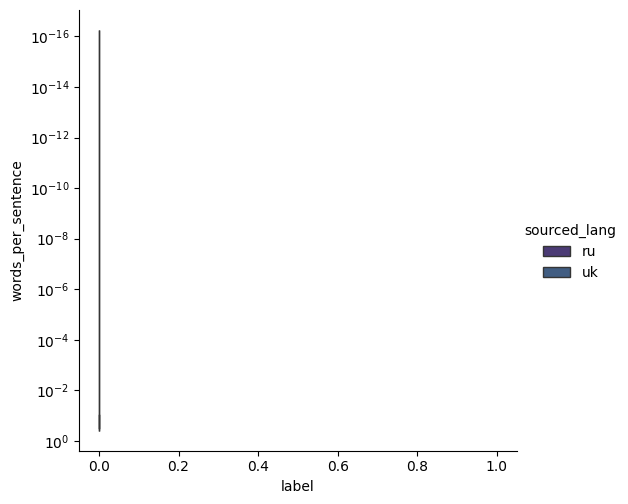

In [16]:
sns.catplot(data=sentence_len,
            y='words_per_sentence',
           x='label', hue='sourced_lang', 
           kind='box')
plt.yscale('log')

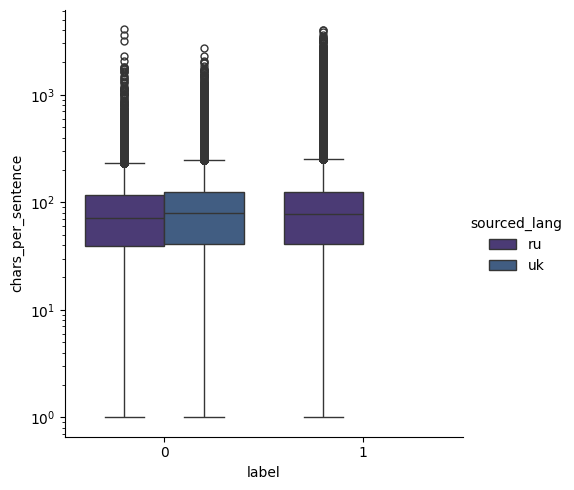

In [17]:
sns.catplot(data=sentence_len,
            y='chars_per_sentence',
           x='label', hue='sourced_lang', 
           kind='box')
plt.yscale('log')

# Amount of adjectives in the messages

In [62]:
morph_uk = pymorphy2.MorphAnalyzer(lang='uk')
morph_ru =  pymorphy2.MorphAnalyzer(lang='ru')
pos_counts = [
    'ADJF',
    'ADJS',
    'NUMR', # more numner - less propagandistic
    'NPRO', # more pronouns - more propagandsitic
]

def get_adjectives_count_in_text(row):
    pos_counter = Counter()
    text, sourced_lang = row['text'], row['sourced_lang']
    
    for token in nltk.word_tokenize(text):
        if sourced_lang == 'uk':
            token_pos = morph_uk.parse(token)[0]
        else: 
            token_pos = morph_ru.parse(token)[0]
        pos_counter[token_pos.tag.POS] += 1
        
    return pd.Series([
        pos_counter[key] for key in pos_counts
    ], index=pos_counts)



# adj_df = adj_sampled.assign(
#     *adj_sampled.progress_apply(get_adjectives_count_in_text, result_type='expand',
#                      axis=1)
# )
# adj_df


100%|██████████| 20000/20000 [01:59<00:00, 167.05it/s]


,ADJF,ADJS,NUMR,NPRO
16084,4,0,0,1
353091,0,0,0,0
790131,7,0,0,0
161906,1,0,0,0
299543,4,0,1,1
...,...,...,...,...
242295,3,0,0,0
315462,3,0,0,1
561135,38,2,0,20
294659,22,0,0,7


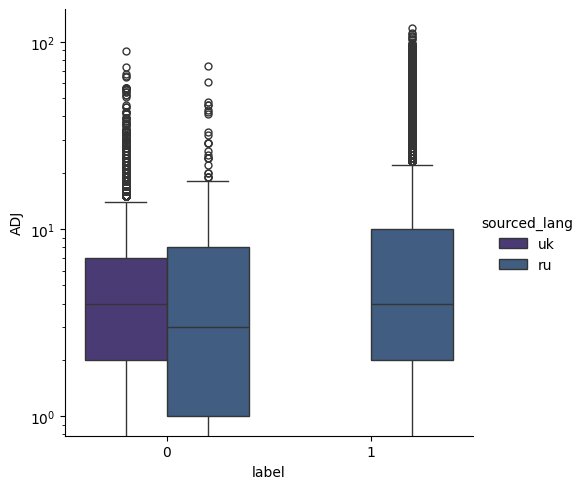

In [76]:
adj_sampled = df.sample(20_000, random_state=42)
pos_df = adj_sampled.progress_apply(get_adjectives_count_in_text, result_type='expand',
                     axis=1)
text_pos_df = adj_sampled.merge(pos_df, left_index=True, right_index=True)
text_pos_df['ADJ'] = text_pos_df['ADJF'] + text_pos_df['ADJS']

sns.catplot(data=text_pos_df,
            y='ADJ',
           x='label', hue='sourced_lang', 
           kind='box')

plt.yscale('log')

In [104]:
adj_sampled = df.sample(100_000, random_state=42)
pos_df = adj_sampled.progress_apply(get_adjectives_count_in_text, result_type='expand',
                     axis=1)
text_pos_df = adj_sampled.merge(pos_df, left_index=True, right_index=True)
text_pos_df['ADJ'] = text_pos_df['ADJF'] + text_pos_df['ADJS']


100%|██████████| 100000/100000 [10:01<00:00, 166.33it/s]


In [105]:
punctuation = set(string.punctuation)     
stopwords_set = ukrainian_stopwords | set(stopwords.words('russian'))

def should_skip_token(token: str):
        return (token in stopwords_set or 
               token in punctuation)
                                          
def count_tokens(text):
    tokens_count = 0

    for i in nltk.word_tokenize(text):
        if not should_skip_token(i):
            tokens_count += 1
    return tokens_count
                                          
                                          
word_counts = text_pos_df['text'].progress_apply(count_tokens)
word_counts


100%|██████████| 100000/100000 [00:33<00:00, 2988.85it/s]


16084     25
353091    13
790131    23
161906     9
299543    46
          ..
96054     48
622456     2
207262    65
652131    21
384813    19
Name: text, Length: 100000, dtype: int64

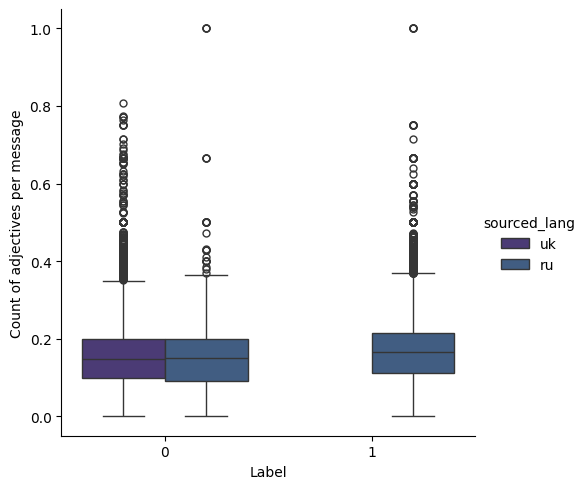

In [107]:
# Count of adjectives per message length
text_pos_len_df['adj_per_word'] = text_pos_len_df['ADJ']  \
/ word_counts
sns.catplot(data=text_pos_len_df,
            y='adj_per_word',
           x='label', hue='sourced_lang', 
           kind='box')

plt.ylabel('Count of adjectives per message')
plt.xlabel('Label')

# plt.savefig('percentage_of_adjective_per_message.pdf')

Text(0.5, 28.999999999999986, 'Label')

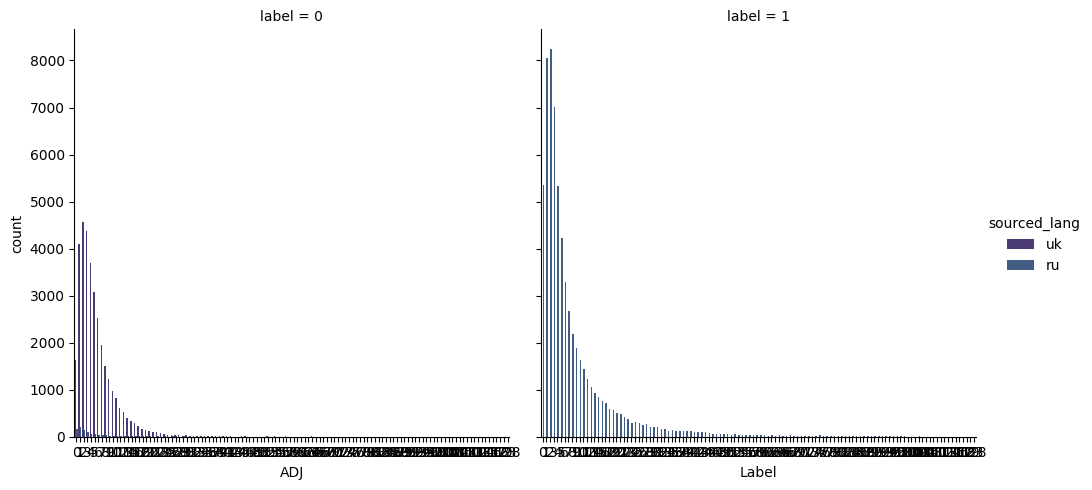

In [90]:
sns.catplot(data=text_pos_df,
        
           x='ADJ', hue='sourced_lang', 
            col='label',
           kind='count')

# plt.ylabel('Count of adjectives per message.pdf')
plt.xlabel('Label')

In [ ]:
g = sns.catplot(data=df, 
            y='channel', 
            col='label', 
            kind='count',
            col_order=[0, 1],
            order=df['channel'].value_counts().index,
            height=7,
                sharey=False,
                hue='sourced_lang'
           )

g.set_axis_labels('Messages count', 'Channel Tag')
g.fig.suptitle('Count of messages per channel')
plt.tight_layout()
# plt.savefig('count_of_messages_per_channel.pdf', bbox_inches='tight')

# What are the most popular bi-and-trigrams

In [112]:
def get_n_gram(df, n):
    punctuation = set(string.punctuation)
    
    def process_text(text):
        # Filter text from url and character

        
        tokens = []
        for i in nltk.word_tokenize(text):
            if not should_skip_token(i):
                tokens.append(i)
                
                
        return nltk.ngrams(tokens, n)

    ngrams_list = df['text'].apply(process_text)
        
    words_list = [ngram for ngram_message in ngrams_list for ngram in ngram_message]
    return Counter(words_list)
        
    # make a total amount of words
    # manually exclude thos

In [113]:
bigrams_counter_df = df.groupby(['label', 'sourced_lang']).progress_apply(partial(get_n_gram, n=2))

100%|██████████| 3/3 [05:25<00:00, 108.53s/it]


In [116]:
pd.DataFrame(bigrams_counter_df.apply(lambda x: x.most_common(50)).reset_index().iloc[1].loc[0], columns=[1,2])

,1,2
0,"(Підписатися, ZN.UA)",31287
1,"(🚀Підписатися, ZN.UA)",28083
2,"('', —)",20629
3,"(👉, Підписатися)",16759
4,"(LB.ua, FB)",15499
5,"(FB, Twitter)",15499
6,"(Twitter, YouTube)",15465
7,"(чату, ZN.UA)",11186
8,"(🚀Приєднатися, чату)",11026
9,"(👉Підписатися, ZN.UA)",10679


In [117]:
trigram_counter_df = df.groupby(['label', 'sourced_lang']).progress_apply(partial(get_n_gram, n=3))

100%|██████████| 3/3 [05:33<00:00, 111.03s/it]


In [118]:
pd.DataFrame(trigram_counter_df.apply(lambda x: x.most_common(50)).reset_index().iloc[1].loc[0], columns=[1,2])

,1,2
0,"(👉, Підписатися, ZN.UA)",16275
1,"(LB.ua, FB, Twitter)",15498
2,"(FB, Twitter, YouTube)",15460
3,"(🚀Приєднатися, чату, ZN.UA)",11025
4,"(🧡, hromadske, підписатися)",3637
5,"(👀, Підписатись, LIGA.net)",2593
6,"(місцеві, пабліки, повідомляють)",2264
7,"(—, Повітряні, сили)",2188
8,"(—, повітряна, тривога)",2185
9,"(України, Володимир, Зеленський)",2153


In [124]:
bigrams_counter_df.reset_index().group

,label,sourced_lang,0
0,0,ru,"{('Эфир', 'сегодня'): 15, ('сегодня', 'начинае..."
1,0,uk,"{('⚠️', '💥'): 189, ('💥', 'ЛЬВІВ'): 1, ('ЛЬВІВ'..."
2,1,ru,"{('Ликвидированный', 'российскими'): 1, ('росс..."


In [139]:
bigram_df = bigrams_counter_df.copy()

bigram_df.loc[0, 'uk'].update(bigram_df.loc[0, 'ru'])
bigram_df = (bigram_df
             .drop(index=[(0, 'ru')])
             .reset_index(level=1)
             .drop(columns=['sourced_lang'])
            .rename(columns={0: 'counter'})
            )


In [180]:
# bigrams_counter_df
# trtrigram_counter_df

# Join them so that the distinction is only made by label
# Print top 50 for each 
negative_stopword_tuples = [
(('Підписатися', 'ZN.UA'), 31287),
(('🚀Підписатися', 'ZN.UA'), 28083),
(("''", '—'), 21035),
(('👉', 'Підписатися'), 16773),
(('Twitter', 'YouTube'), 16137),
(('LB.ua', 'FB'), 15499),
(('FB', 'Twitter'), 15499),
(('»', '—'), 11329),
(('чату', 'ZN.UA'), 11186),
(('🚀Приєднатися', 'чату'), 11026),
(('👉Підписатися', 'ZN.UA'), 10679),
(("''", '–'), 9234),
(("''", '``'), 7636),
(('»', '«'), 5979),
(('hromadske', 'підписатися'), 3754),
(('🧡', 'hromadske'), 3638),
(('»', '–'), 3385),
(('👀', 'Підписатись'), 2643),
(('Підписатись', 'LIGA.net'), 2595),
(('зв', '\''), 2438)
]
positive_stopword_tuples = [
(('»', '—'), 19328),
(('Сайт', 'Дзен'), 18486),
(('🟥', 'Сайт'), 16606),
(('👉', 'Подписаться'), 16293),
(('»', '«'), 15987),
(('Новости', 'Подписаться'), 10389),
(('Яндекс', 'Новости'), 9500),
(('правду', 'Подпишись'), 9020),
(('Дзен', 'Подписаться'), 8988),
(('💬Чат', 'https'), 6862),
(('Дзен', 'Яндекс'), 5540),
(('Конфликт', 'Подписаться'), 5134),
(('🤴Царьград.ТВ', 'Не'), 5070),
(('Украине', '✅Подписаться✅'), 4835),
(('Украина', 'new_militarycolumnist'), 11054),   
 (("''", '``'), 7711)
]

for i, values in zip([0, 1], [
  negative_stopword_tuples,
  positive_stopword_tuples
]):
    for t in values:
        del bigram_df.loc[i]['counter'][t[0]]
# Manully filter words that are not relevant
# Draw a plot with two columns 

In [182]:
bigram_vis_df = pd.concat([pd.DataFrame(bigram_df.loc[0]['counter'].most_common(10), columns=['name', 'count']).assign(label=0),
          pd.DataFrame(bigram_df.loc[1]['counter'].most_common(10), columns=['name', 'count']).assign(label=1)])

In [183]:
bigram_vis_df['name'] =bigram_vis_df['name'].astype('str')

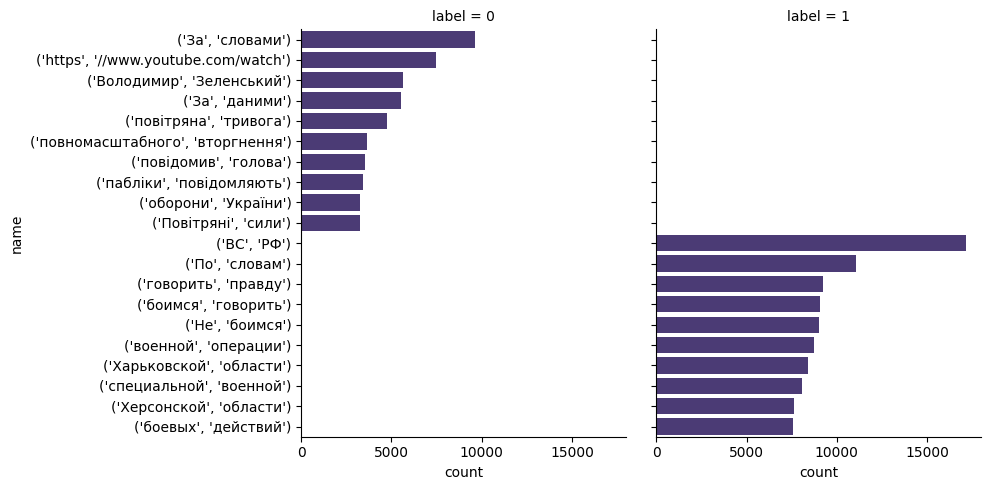

In [184]:
sns.catplot(data=bigram_vis_df, y='name', x='count', col='label', kind='bar')

In [185]:
from IPython.display import display

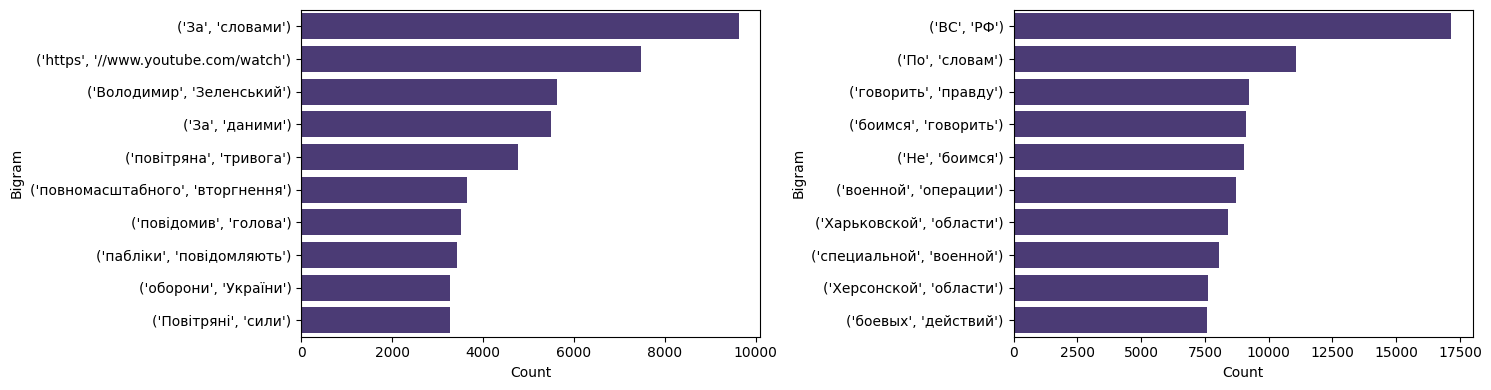

In [190]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

for row_idx, label in enumerate(bigram_vis_df['label'].unique()):
    temp_df = bigram_vis_df[bigram_vis_df['label'] == label]
    sns.barplot(
        data=temp_df, 
        y='name',
        x='count',
        ax=axes[row_idx])
    axes[row_idx].set_xlabel('Count')
    axes[row_idx].set_ylabel('Bigram')
    
plt.tight_layout()
# plt.savefig('bigram_barplot.pdf')


# What channels were used 

In [ ]:
channel_count = df.groupby(['label', 'sourced_lang'])['channel'].value_counts()
channel_count.index.names = ['Label', 'Language', 'Channel Tag']
channel_count.name = 'Count'
# print(channel_count.reset_index().set_index(['Label', 'Language']).to_latex())